In [10]:
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.stats import norm
from nsepython import nsefetch
from scipy import optimize
import matplotlib.pyplot as plt

In [26]:
url = "https://www.nseindia.com/api/option-chain-indices?symbol=NIFTY"
data = nsefetch(url)

In [22]:
call_data = []
for row in data['records']['data']:
    ce = row.get('CE')
    if ce:
        Strike = row['CE']['strikePrice']
        Expiry = row['CE']['expiryDate']
        Call_price = row['CE']['lastPrice']
        Spot_price = data['records']['underlyingValue']
        call_data.append({"Strike" : Strike,
                         "Expiry" : Expiry,
                         "Call_price" : Call_price,
                         "Spot_price" : Spot_price})
call_df = pd.DataFrame(call_data)


def implied_vol_cal(V, S_0, X, r, T):
    def black_schole_price(x):
        d_1 = (np.log(S_0/X) + (r + ((x**2)/2))*T)/(x*np.sqrt(T))
        d_2 = d_1 - (x*np.sqrt(T))
    
        return (S_0*(norm.cdf(d_1)) - X*(np.exp((-r)*T)*norm.cdf(d_2)) - V)
        
    try:
        return optimize.brentq(black_schole_price, 1e-6, 5)
    except ValueError:
        try:
            return optimize.brentq(black_schole_price, 1e-6, 10)
        except ValueError:
            np.nan

iv_list = []
time_to_maturity_series = []
for i in range(len(call_df)):
    V = call_df['Call_price'][i]
    X = call_df['Strike'][i]
    S_0 = call_df['Spot_price'][i]
    r = 0.1
    expiry = pd.to_datetime(call_df['Expiry'][i])
    time_to_maturity = expiry - pd.Timestamp.today()
    T = time_to_maturity.total_seconds()/(365 * 24 * 60 * 60)
    time_to_maturity_series.append(T)
    iv = implied_vol_cal(V, S_0, X, r, T)
    iv_list.append(iv)

call_df['IV'] = iv_list
call_df['Time_to_maturity'] = time_to_maturity_series

call_df = call_df[call_df['IV'] > 0.1]

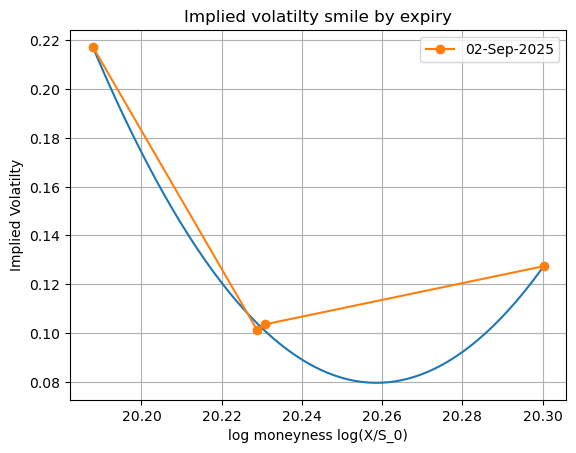

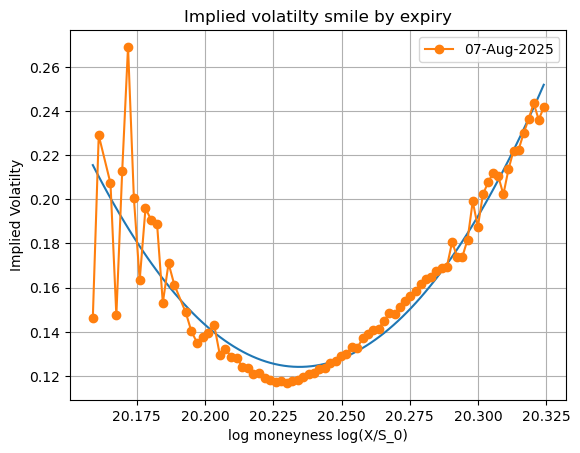

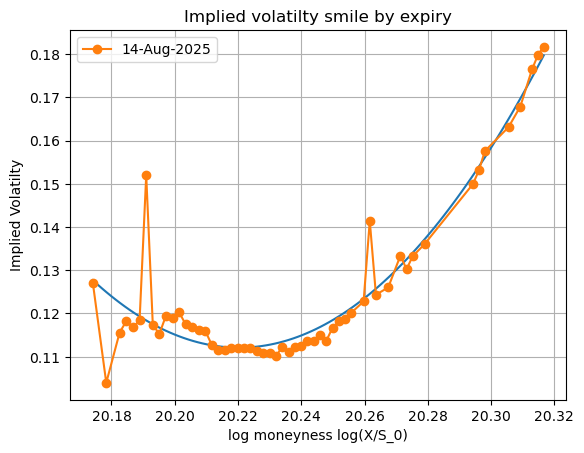

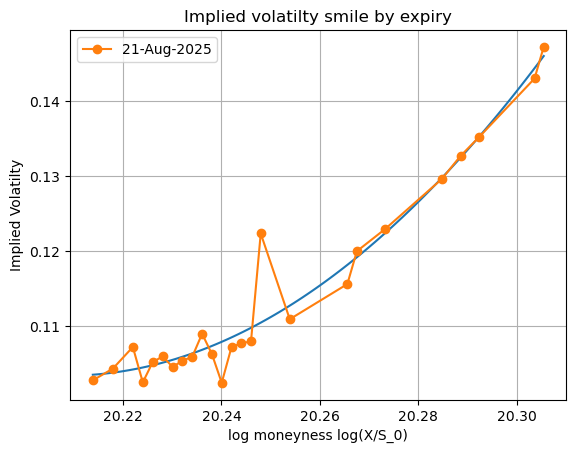

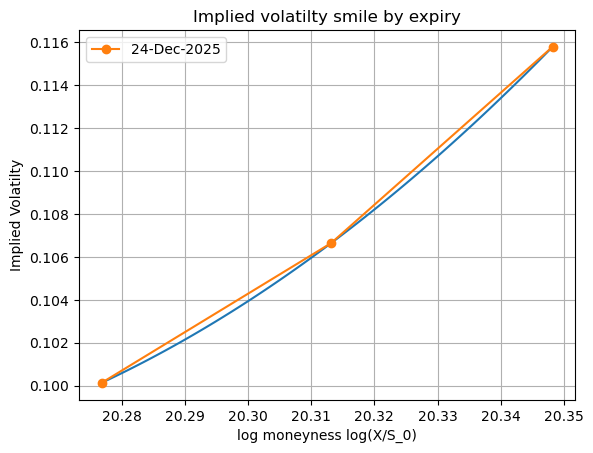

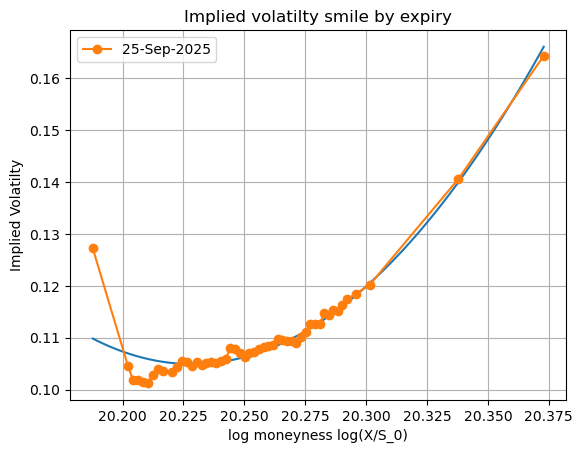

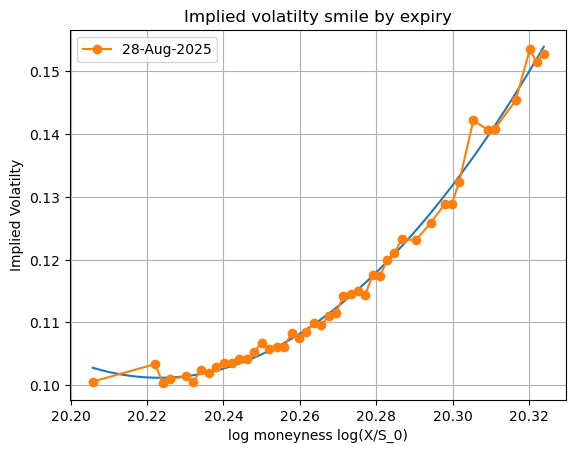

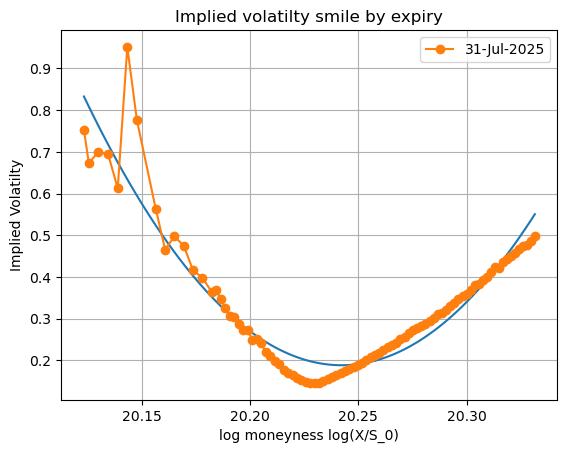

In [28]:
call_df.dropna(inplace = True)
call_df['log_moneyness'] = np.log(call_df['Strike']/np.exp(r*call_df['Time_to_maturity'])*call_df['Spot_price'])
call_df = call_df[(call_df['Strike'] > 0.8*call_df['Spot_price']) & (call_df['Strike'] < 1.2*call_df['Spot_price'])]

for expiry, group in call_df.groupby('Expiry'):
    group = group.sort_values('log_moneyness')
    model = np.poly1d(np.polyfit(group['log_moneyness'], group['IV'], 2))
    polyline = np.linspace(group['log_moneyness'].iloc[0], group['log_moneyness'].iloc[-1], 100)
    plt.plot(polyline, model(polyline))
    plt.plot(group['log_moneyness'], group['IV'], marker = 'o', label = str(expiry))
    plt.xlabel('log moneyness log(X/S_0)')
    plt.ylabel('Implied Volatilty')
    plt.title('Implied volatilty smile by expiry')
    plt.legend()
    plt.grid(True)
    plt.show()